# Beginner PyTorch: Train a Tiny Neural Network on a Toy Dataset
    
This notebook shows a minimal, **fully functional** PyTorch workflow you can run on a Mac (including Apple Silicon like M1/M2/M3/M4 with **MPS**).  
We will:
- Generate a tiny **synthetic 2‑class dataset** (no downloads needed)
- Build a small **MLP classifier**
- **Train** with cross‑entropy + Adam
- Track **loss & accuracy** for training and validation
- Visualize **learning curves** and the **decision boundary**
    
**Tip:** Run cells from top to bottom. If you’re new to Jupyter, click a cell and press **Shift+Enter** to run it.


## 1) Setup
    
**In plain English:**  
We import PyTorch and a few helpers. If you don’t have PyTorch yet, uncomment the `pip install` line, run it once, and then **Restart Kernel**.


In [1]:
# If PyTorch isn't installed, uncomment the line below, run once, then restart the kernel.
# !pip install torch torchvision torchaudio --quiet

import math
import random
from dataclasses import dataclass

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np

# Make plots a bit crisper in notebooks
%matplotlib inline


## 2) Pick the device (MPS on Apple Silicon, else CPU)
    
**In plain English:**  
If your Mac GPU is available via **MPS**, we’ll use it. Otherwise we’ll use CPU. This is automatic.


In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)


Using device: mps


## 3) Make a tiny toy dataset (no downloads)
    
**In plain English:**  
We create two “clouds” (blobs) of 2D points:
- Class 0 centered around (-1, -1)
- Class 1 centered around (+1, +1)
    
Each point is just an (x, y) coordinate. The model will learn to separate the two classes.


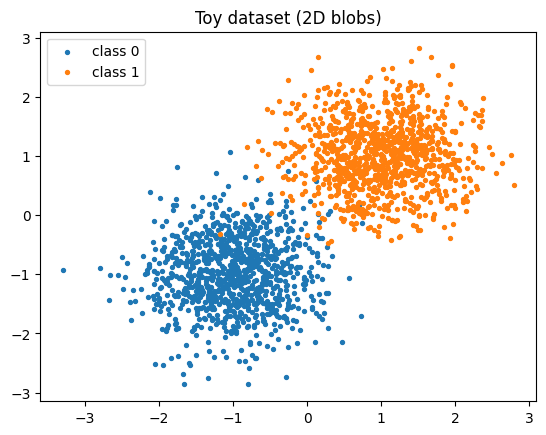

In [4]:
@dataclass
class ToyConfig:
    n_per_class: int = 1000   # points per class
    std: float = 0.6          # how spread out the points are
    seed: int = 42            # reproducibility

cfg = ToyConfig()
g = torch.Generator().manual_seed(cfg.seed)

# Class 0 around (-1, -1)
mean0 = torch.tensor([-1.0, -1.0])
class0 = mean0 + cfg.std * torch.randn((cfg.n_per_class, 2), generator=g)
y0 = torch.zeros(cfg.n_per_class, dtype=torch.long)

# Class 1 around (+1, +1)
mean1 = torch.tensor([+1.0, +1.0])
class1 = mean1 + cfg.std * torch.randn((cfg.n_per_class, 2), generator=g)
y1 = torch.ones(cfg.n_per_class, dtype=torch.long)

X = torch.vstack([class0, class1])  # (2*n, 2)
y = torch.hstack([y0, y1])          # (2*n,)

# Quick scatter to visualize
plt.figure()
plt.scatter(X[:cfg.n_per_class,0], X[:cfg.n_per_class,1], s=8, label="class 0")
plt.scatter(X[cfg.n_per_class:,0], X[cfg.n_per_class:,1], s=8, label="class 1")
plt.title("Toy dataset (2D blobs)")
plt.legend()
plt.show()


## 4) Wrap data in a `Dataset` and `DataLoader`s
    
**In plain English:**  
- A `Dataset` knows how to return one item and how many items there are.  
- A `DataLoader` pulls items in **mini-batches** and can **shuffle** them for training.


In [5]:
class BlobsDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X.float()
        self.y = y.long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

full_ds = BlobsDataset(X, y)

# Train/validation split (80/20)
n_total = len(full_ds)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=g)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

len(train_ds), len(val_ds)


(1600, 400)

## 5) Define a tiny neural network (MLP)
    
**In plain English:**  
We use a simple **multi‑layer perceptron (MLP)**:
- Input: 2 numbers (x, y)
- Hidden layers with **ReLU** activation (lets the model learn curves, not just straight lines)
- Output: 2 numbers (scores for “class 0” and “class 1”)


In [6]:
class TinyMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=16, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x):
        return self.net(x)

model = TinyMLP().to(device)
model


TinyMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

### ReLU()

<img src="./ReLU.png" alt="Alt text" width="300" height="200"/>


## 6) Choose loss function and optimizer
    
**In plain English:**  
- **Cross‑entropy** measures how wrong our predicted class probabilities are.  
- **Adam** optimizer adjusts the model’s weights to reduce that loss.  
- **Learning rate** controls how big each adjustment is.


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


## 7) Training loop (with validation each epoch)
    
**In plain English:**  
For each epoch (pass over the data):
1. **Training:** feed batches, compute loss, backpropagate, update weights.
2. **Validation:** evaluate on held‑out data (no updates) to gauge generalization.
    
We record loss and accuracy for both training and validation.


In [9]:
def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

epochs = 40
for epoch in range(1, epochs + 1):
    # --- Train ---
    model.train()
    running_loss, running_acc, count = 0.0, 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        batch_size = yb.size(0)
        running_loss += loss.item() * batch_size
        running_acc  += accuracy_from_logits(logits, yb) * batch_size
        count += batch_size

    train_loss = running_loss / count
    train_acc  = running_acc  / count

    # --- Validate ---
    model.eval()
    v_loss, v_acc, v_count = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            batch_size = yb.size(0)
            v_loss += loss.item() * batch_size
            v_acc  += accuracy_from_logits(logits, yb) * batch_size
            v_count += batch_size

    val_loss = v_loss / v_count
    val_acc  = v_acc  / v_count

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.3f} "
              f"| val_loss={val_loss:.4f} acc={val_acc:.3f}")


Epoch 01 | train_loss=0.4040 acc=0.877 | val_loss=0.0584 acc=0.998
Epoch 05 | train_loss=0.0321 acc=0.989 | val_loss=0.0187 acc=0.995
Epoch 10 | train_loss=0.0314 acc=0.989 | val_loss=0.0181 acc=0.995
Epoch 15 | train_loss=0.0309 acc=0.988 | val_loss=0.0189 acc=0.995
Epoch 20 | train_loss=0.0306 acc=0.989 | val_loss=0.0201 acc=0.995
Epoch 25 | train_loss=0.0315 acc=0.988 | val_loss=0.0166 acc=0.995
Epoch 30 | train_loss=0.0303 acc=0.991 | val_loss=0.0165 acc=0.998
Epoch 35 | train_loss=0.0309 acc=0.990 | val_loss=0.0186 acc=0.995
Epoch 40 | train_loss=0.0300 acc=0.989 | val_loss=0.0181 acc=0.995


### Cross-Entropy Loss (in plain English)

Think of cross-entropy loss as a way to measure **how surprised our model is** when it makes a prediction.

- If the model is **very confident and correct** → low loss (almost 0).
- If the model is **confident but wrong** → very high loss.
- If the model is **unsure** (like 50/50 on a coin flip) → medium loss.

It basically asks: *“How many bits of information would I need to correct the model’s prediction to the truth?”*

---

#### Everyday analogy
Imagine you’re guessing the weather:
- If you say **“100% sunny”** and it really is sunny → 🎉 no penalty.
- If you say **“100% sunny”** but it rains → 🌧 huge penalty (you were *confident but wrong*).
- If you say **“50% sunny, 50% rain”** and it rains → 🤔 small penalty (you were hedging).

Cross-entropy punishes **over-confident mistakes** much more than cautious uncertainty.

---


### Visualization of cross-entropy

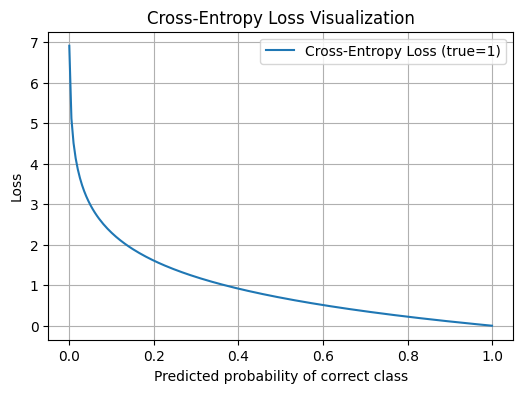

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# True label = 1 (e.g., "cat")
true_label = 1  

# Predicted probability of "cat"
p = np.linspace(0.001, 0.999, 200)

# Cross-entropy loss for true label = 1
loss = -np.log(p)

plt.figure(figsize=(6,4))
plt.plot(p, loss, label="Cross-Entropy Loss (true=1)")
plt.xlabel("Predicted probability of correct class")
plt.ylabel("Loss")
plt.title("Cross-Entropy Loss Visualization")
plt.grid(True)
plt.legend()
plt.show()


## 8) Plot learning curves
    
**In plain English:**  
Loss should trend down; accuracy should trend up and stabilize.  
If training accuracy is much higher than validation accuracy, that’s **overfitting**.


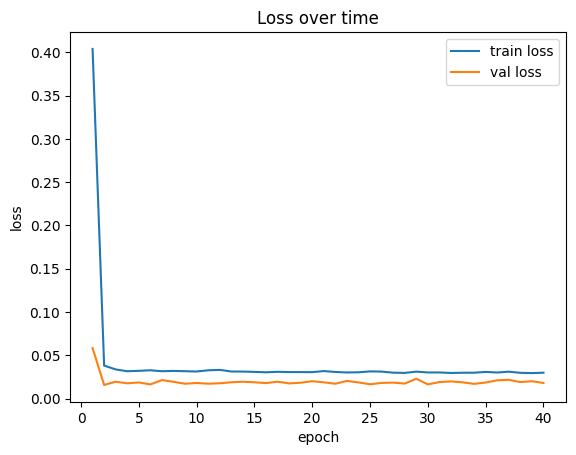

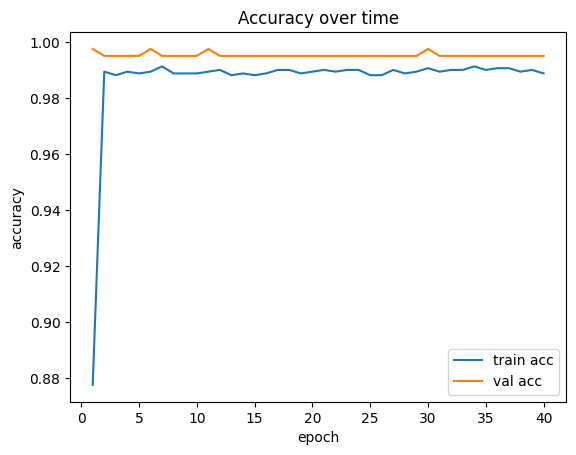

In [10]:
epochs_axis = np.arange(1, epochs + 1)

plt.figure()
plt.plot(epochs_axis, history["train_loss"], label="train loss")
plt.plot(epochs_axis, history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss over time")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_axis, history["train_acc"], label="train acc")
plt.plot(epochs_axis, history["val_acc"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy over time")
plt.legend()
plt.show()


## 9) Visualize the decision boundary
    
**In plain English:**  
We color a grid of points by the class the model predicts. This reveals the boundary it learned between the two blobs.


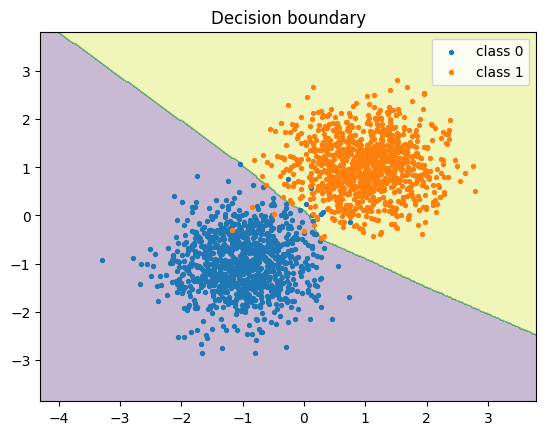

In [11]:
def plot_decision_boundary(model, X_cpu, y_cpu, device):
    model.eval()
    x_min, x_max = X_cpu[:,0].min()-1.0, X_cpu[:,0].max()+1.0
    y_min, y_max = X_cpu[:,1].min()-1.0, X_cpu[:,1].max()+1.0

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
    with torch.no_grad():
        logits = model(torch.from_numpy(grid).to(device))
        preds = logits.argmax(dim=1).view(xx.shape).cpu().numpy()

    plt.figure()
    plt.contourf(xx, yy, preds, alpha=0.3)
    plt.scatter(X_cpu[y_cpu==0,0], X_cpu[y_cpu==0,1], s=8, label="class 0")
    plt.scatter(X_cpu[y_cpu==1,0], X_cpu[y_cpu==1,1], s=8, label="class 1")
    plt.title("Decision boundary")
    plt.legend()
    plt.show()

plot_decision_boundary(model, X.cpu().numpy(), y.cpu().numpy(), device)


## 10) Make a few predictions
    
**In plain English:**  
We pass a few sample points and see which class the model chooses.


In [12]:
test_points = torch.tensor([[-1.5, -0.8], [1.2, 0.9], [0.0, 0.0]], dtype=torch.float32).to(device)
with torch.no_grad():
    logits = model(test_points)
    probs = torch.softmax(logits, dim=1)
    preds = probs.argmax(dim=1).cpu().numpy()

print("Test points (x,y):")
print(test_points.cpu().numpy())
print("Predicted classes:", preds)
print("Class probabilities:\n", probs.cpu().numpy())


Test points (x,y):
[[-1.5 -0.8]
 [ 1.2  0.9]
 [ 0.   0. ]]
Predicted classes: [0 1 0]
Class probabilities:
 [[9.99878287e-01 1.21742676e-04]
 [3.36361300e-05 9.99966383e-01]
 [5.78833103e-01 4.21166897e-01]]


## What just happened (super simple):
- **Data:** 2D points labeled 0/1  
- **Model:** A small MLP that maps (x, y) → scores for each class  
- **Loss:** How wrong we are (lower is better)  
- **Backprop:** Nudges the model to be less wrong next time  
- **Validation:** Tests generalization on data we didn’t train on  
- **Decision boundary:** Picture of the model’s learned separation
    
## Ideas to try next
- Increase hidden size (e.g., 32 or 64)
- Train longer or tweak learning rate (e.g., 5e‑3 or 1e‑2)
- Add **weight decay** to Adam (e.g., `weight_decay=1e-4`)
- Insert **dropout** between layers to reduce overfitting
- Try a trickier synthetic dataset (e.g., spirals) to see non‑linear boundaries
